In [1]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, r2_score

import os
import seaborn as sns
import matplotlib.collections as clt
import ptitprince as pt

import sys
np.set_printoptions(threshold=sys.maxsize)


/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br />
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

#### Plot examplar encoding matrix:

(-0.5, 7816.5, 2741.5, -0.5)

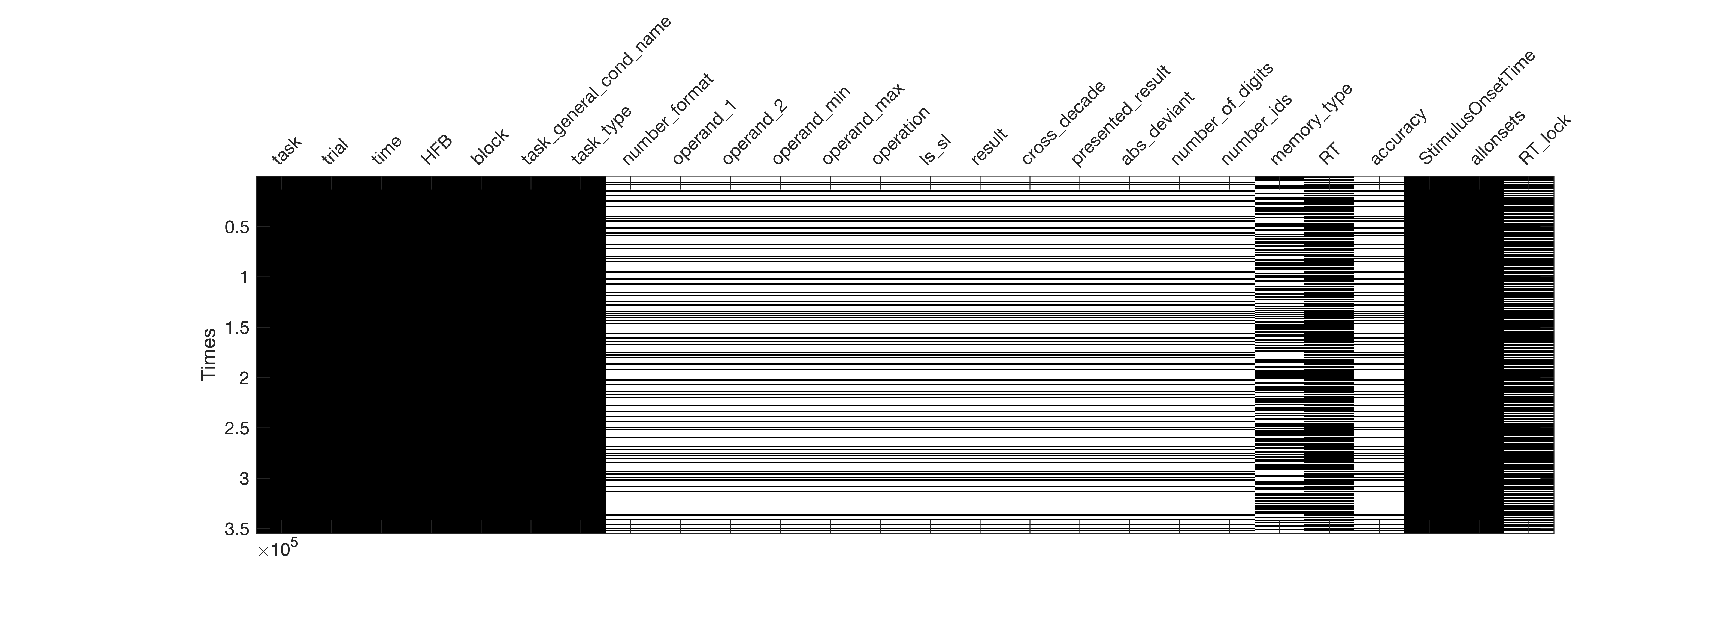

In [2]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/figures/encoding_matrix.png') 
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(im)
plt.axis('off')

### Load the data



In [3]:
data = pd.read_csv('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data_61.csv') 
data.head()

,task,trial,time,elect,HFB,block,task_general_cond_name,task_type,number_format,operand_1,...,cross_decade,presented_result,abs_deviant,number_of_digits,memory_type,RT,accuracy,StimulusOnsetTime,allonsets,RT_lock
0,7,1,0.000,61,-0.437685,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
1,7,1,0.002,61,-0.514633,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
2,7,1,0.004,61,-0.598166,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
3,7,1,0.006,61,-0.672080,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
4,7,1,0.008,61,-0.721583,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653


In [4]:
# Set extreme values to zero (double check spike exclusion)
data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
# Recode task name
data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 2
data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1

### Plot all blocks concatenated

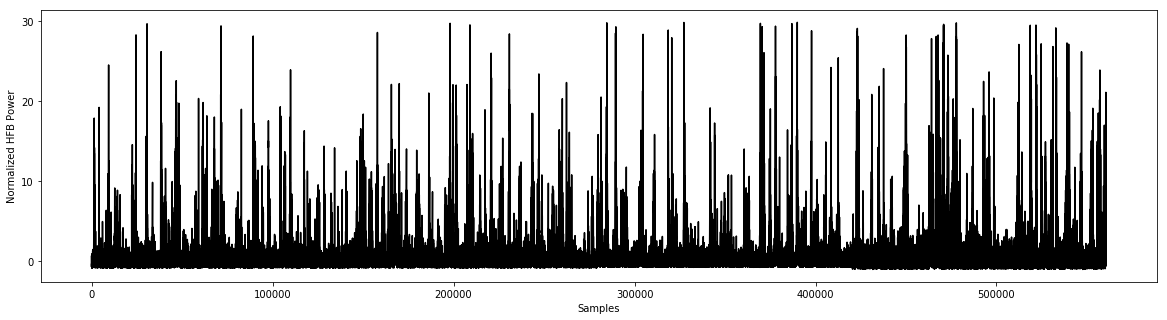

In [5]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data.loc[:,'HFB'], color='k')
plt.xlabel('Samples')
plt.ylabel('Normalized HFB Power')
plt.rcParams.update({'font.size': 20})

### Plot blocks saparated

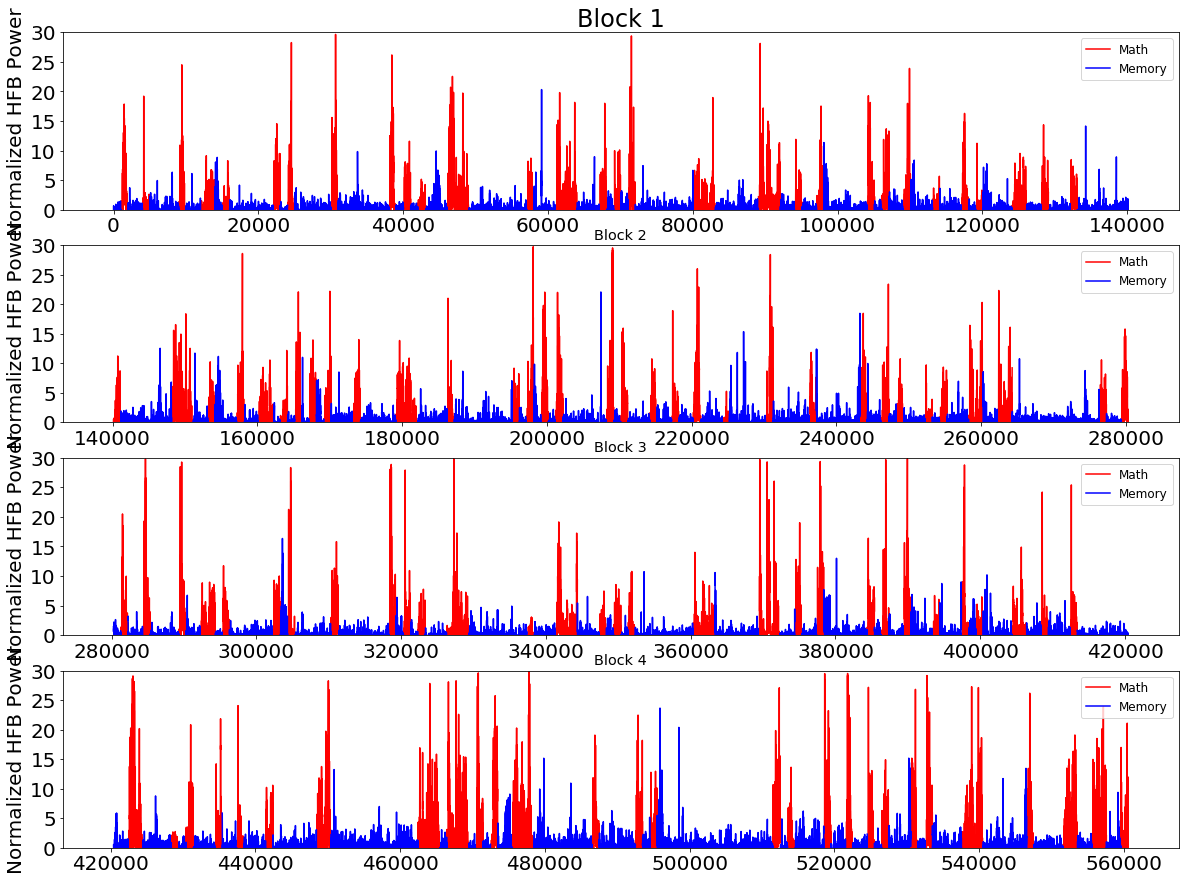

In [6]:
n_blocks = np.int(np.max(data.loc[:,'block']))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
math_trials = data.loc[:,'HFB'].copy()
math_trials[data.loc[:,'task_general_cond_name']!=2] = np.nan
memo_trials = data.loc[:,'HFB'].copy()
memo_trials[data.loc[:,'task_general_cond_name']!=1] = np.nan

for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(math_trials[data.loc[:,'block']==i+1], 'r', label="Math")
    ax[i].plot(memo_trials[data.loc[:,'block']==i+1], 'b', label="Memory")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    plt.rcParams.update({'font.size': 12}) 
    ax[i].set_ylabel('Normalized HFB Power')
    ax[i].legend()


In [7]:
# Overall activity 
my_pal = {1: 'blue', 2: 'red'}


([<matplotlib.axis.YTick at 0x1042b2c50>,
 <a list of 2 Text yticklabel objects>)

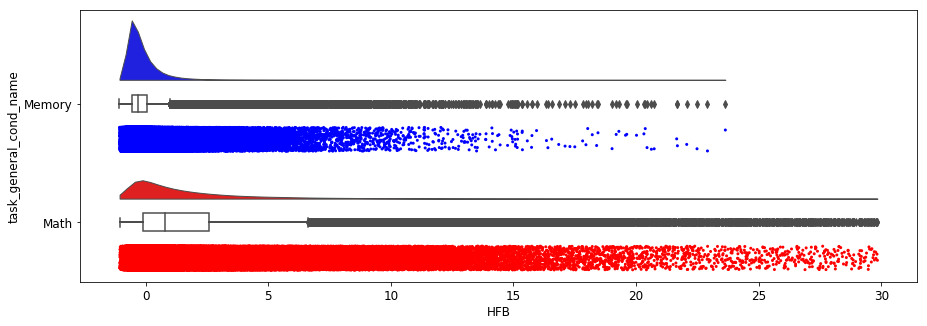

In [8]:
f, ax = plt.subplots(figsize=(15, 5))
ax=pt.RainCloud(x = 'task_general_cond_name', y = 'HFB', data = data, palette = my_pal, bw = 0.1,
                 width_viol = 1, ax = ax, orient = 'h', move = .3)
plt.rcParams.update({'font.size': 14}) 
plt.yticks(np.arange(2), ('Memory', 'Math'))

/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


([<matplotlib.axis.YTick at 0x1c3a4cbc50>,
 <a list of 2 Text yticklabel objects>)

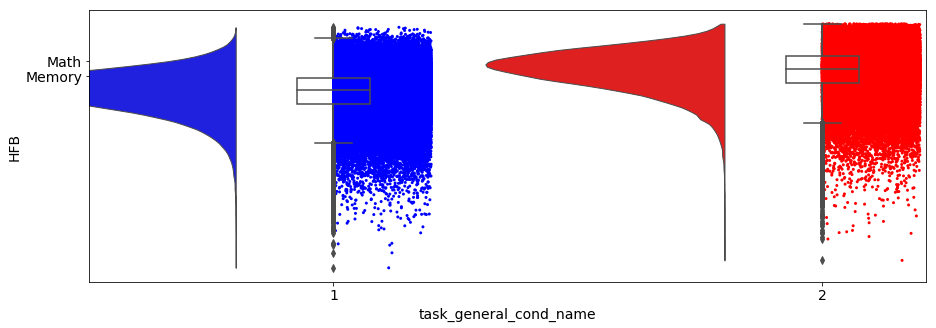

In [9]:
# With log transformed data
data_log = data.copy()
data_log.loc[:, 'HFB'] = np.log(data_log.loc[:, 'HFB']+np.abs(np.min(data_log.loc[:, 'HFB']+1)))

# with log transformed data
# Overall activity 
f, ax = plt.subplots(figsize=(15, 5))
ax=pt.RainCloud(x = 'task_general_cond_name', y = 'HFB', data = data_log, palette = my_pal, bw = 0.1,
                 width_viol = 1, ax = ax, orient = 'v', move = 0.1)
plt.rcParams.update({'font.size': 14}) 
plt.yticks(np.arange(2), ('Memory', 'Math'))

In [10]:
data_log.loc[:, 'HFB']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10       -1.357973
11       -0.619101
12       -0.343108
13       -0.332839
14       -0.576453
15       -1.164338
16       -2.697677
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22       -4.305286
23       -3.484746
24       -3.744078
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
            ...   
560530    1.174678
560531    1.388145
560532    1.587252
560533    1.783937
560534    1.964354
560535    2.111983
560536    2.223480
560537    2.302292
560538    2.345050
560539    2.339370
560540    2.273390
560541    2.146470
560542    1.977221
560543    1.806868
560544    1.691364
560545    1.661416
560546    1.687032
560547    1.712718
560548    1.710929
560549    1.693902
560550    1.701841
560551    1.

### Selec the main feature: task:

In [11]:
features = np.array(data_log.loc[:,'task_general_cond_name'])
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

#### Select feature and add delayed versions

In [12]:
# Define features
features = np.array(data.loc[:,'task_general_cond_name'])
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

# Reshape features
features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)

# Add delayed features
fs = 500
time_window = 0.02;

start = 0; stop = 1.5; step = time_window
delays = np.arange(start, stop+step, step)
n_delays = int(len(delays))

X_delayed = np.zeros((trials,1,n_delays,times))
for i in range(trials):
    for ii in range(n_delays):
        window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
        X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))

Text(0.5,1,'Time-Delayed Task Condition')

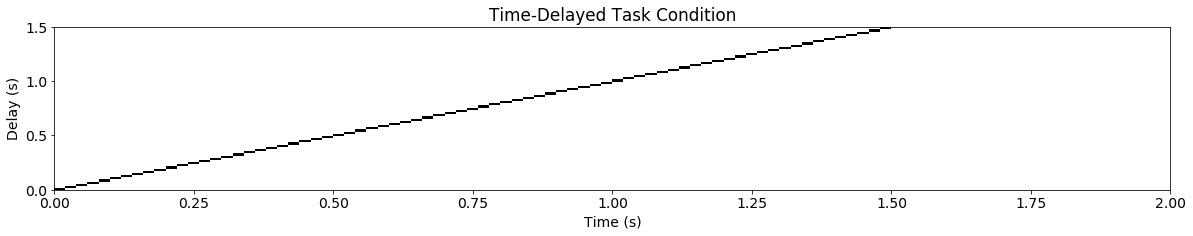

In [13]:
# Plot
times = np.unique(data.loc[:,'time'])
fig, ax = plt.subplots(figsize=(20, 3))
ax.pcolormesh(times, delays,
              X_delayed[1,0,:,:], cmap='binary')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Task Condition')

In [14]:
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

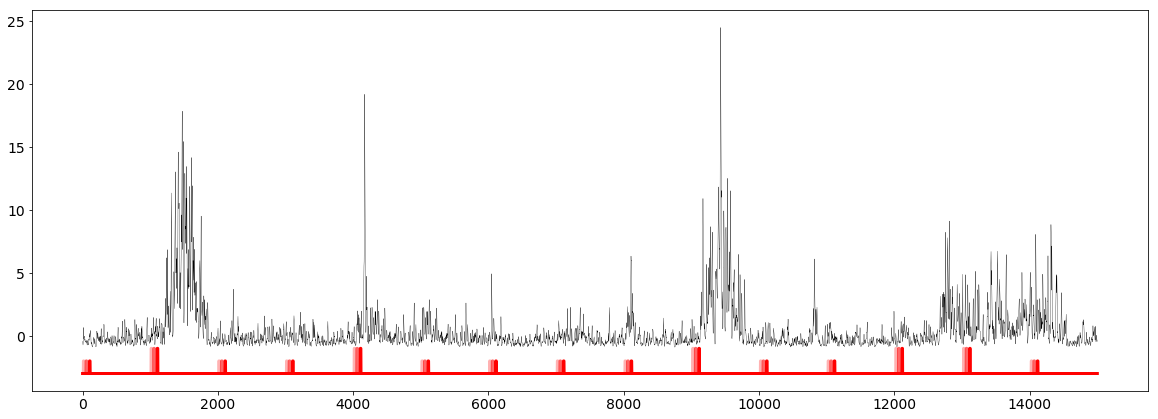

In [15]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = plt.plot(data.loc[0:15000,'HFB'], 'k', linewidth=0.3)
ax = plt.plot(X_env[0:15000,10]-3, color = [1, 0, 0, 1], linewidth=3)
ax = plt.plot(X_env[0:15000,5]-3, color = [1, 0, 0, 0.6], linewidth=3)
ax = plt.plot(X_env[0:15000,1]-3, color = [1, 0, 0, 0.3], linewidth=3)

In [16]:
# Define the dependent variable
y = np.array(data.loc[:,'HFB']) # HFB

# Fit the model
est = make_pipeline(StandardScaler(), Ridge())
est.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

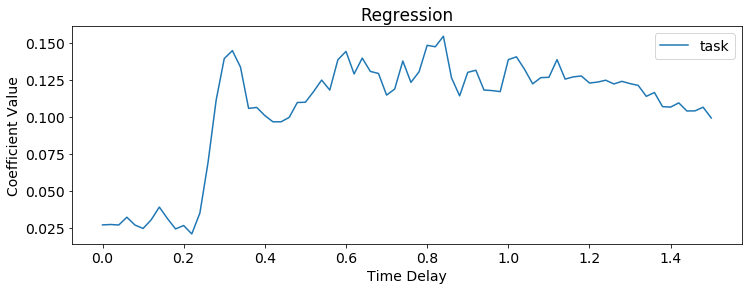

In [17]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'task')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [18]:
data_math = data.loc[data.loc[:,'task_general_cond_name'] == 2,:]

In [22]:
## Cross validation
n_cv_iterations = 10
indices = np.arange(1000)
n_inds = indices.shape[0]
cv_example = cv.ShuffleSplit(n_inds, n_iter=n_cv_iterations)
plot_cv_indices(cv_example)


NameError: name 'cv' is not defined

In [23]:
data_math = data.loc[data.loc[:,'task_general_cond_name'] == 2,:]
features = np.array(data_math.loc[:,'result'])
times = np.shape(np.unique(data_math.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data_math)
trials = int(r/times)

# Reshape features
features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)

# Add delayed features
fs = 500
time_window = 0.02;
#n_delays = 100
#delays = np.linspace(1, 2, 100)

start = 0; stop = 1.5; step = time_window
delays = np.arange(start, stop+step, step)
n_delays = int(len(delays))

X_delayed = np.zeros((trials,1,n_delays,times))
for i in range(trials):
    for ii in range(n_delays):
        window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
        X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))
        
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

In [20]:
np.shape(y)

(560560,)

In [24]:
# Define the dependent variable
y = np.array(data_math.loc[:,'HFB']) # HFB

# Fit the model
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

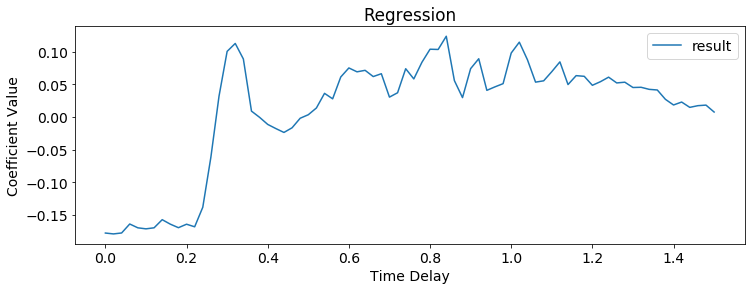

In [25]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'result')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [27]:
predictions = est.predict(X_env)



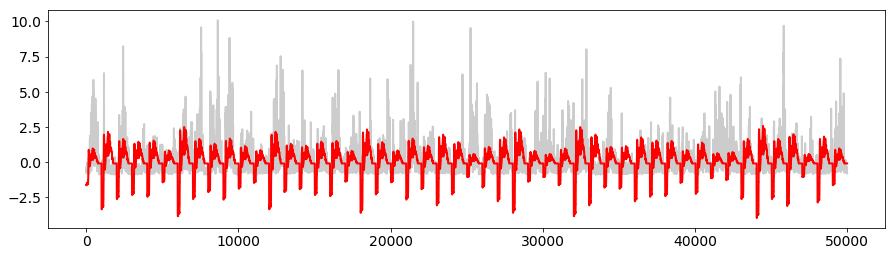

In [29]:
np.correlate(y,predictions)

array([659718.60298036])

In [30]:
def custom_cv_2folds(X):
    n = X.shape[0]
    i = 1
    while i <= 2:
    idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
    yield idx, idx
    i += 1
    
>>> custom_cv = custom_cv_2folds(X)
>>> cross_val_score(clf, X, y, cv=custom_cv)
array([1.        , 0.973...])

IndentationError: expected an indented block (<ipython-input-30-dd9b5cedeee5>, line 5)

In [18]:
data_1 = data[data.block > 1]
X_env_1 = X_env[data.loc[:,'block'] > 1]

y_1 = np.array(data_1.loc[:,'HFB']) # HFB

# Fit the model
est = make_pipeline(StandardScaler(), Ridge())
est.fit(X_env_1, y_1)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

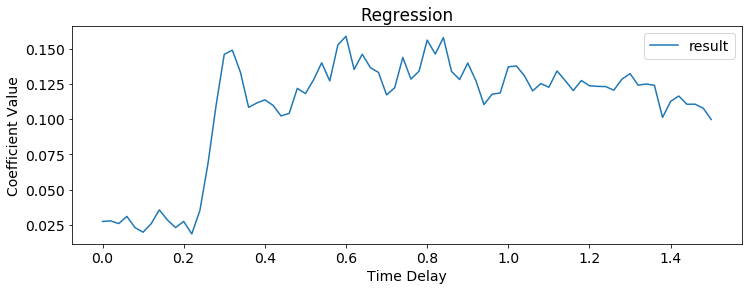

In [19]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'result')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [20]:
X_env_2 = X_env[data.loc[:,'block']==1]


In [21]:
predictions = est.predict(X_env_2)


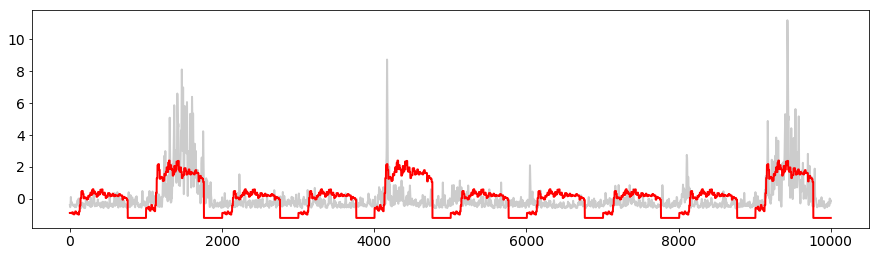

In [22]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(scale(y[0:10000]), color='k', alpha=.2, lw=2)
ax.plot(scale(predictions[0:10000]), color='r', lw=2)




In [64]:
B = predictions.T

In [65]:
A = y.T

In [66]:
A.shape

(560560,)

In [67]:
y.shape

(560560,)

In [73]:
A.shape

(560560,)

In [19]:

data.loc[:,'trial']

0           1
1           1
2           1
3           1
4           1
5           1
6           1
7           1
8           1
9           1
10          1
11          1
12          1
13          1
14          1
15          1
16          1
17          1
18          1
19          1
20          1
21          1
22          1
23          1
24          1
25          1
26          1
27          1
28          1
29          1
         ... 
560530    708
560531    708
560532    708
560533    708
560534    708
560535    708
560536    708
560537    708
560538    708
560539    708
560540    708
560541    708
560542    708
560543    708
560544    708
560545    708
560546    708
560547    708
560548    708
560549    708
560550    708
560551    708
560552    708
560553    708
560554    708
560555    708
560556    708
560557    708
560558    708
560559    708
Name: trial, Length: 560560, dtype: int64

In [20]:
data_math = data.loc[data.loc[:,'task_general_cond_name'] == 2,:]
features = np.array(data_math.loc[:,'result'])
times = np.shape(np.unique(data_math.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data_math)
trials = int(r/times)

# Reshape features
features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)

# Add delayed features
fs = 500
time_window = 0.02;
#n_delays = 100
#delays = np.linspace(1, 2, 100)

start = 0; stop = 1.5; step = time_window
delays = np.arange(start, stop+step, step)
n_delays = int(len(delays))

X_delayed = np.zeros((trials,1,n_delays,times))
for i in range(trials):
    for ii in range(n_delays):
        window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
        X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))
        
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

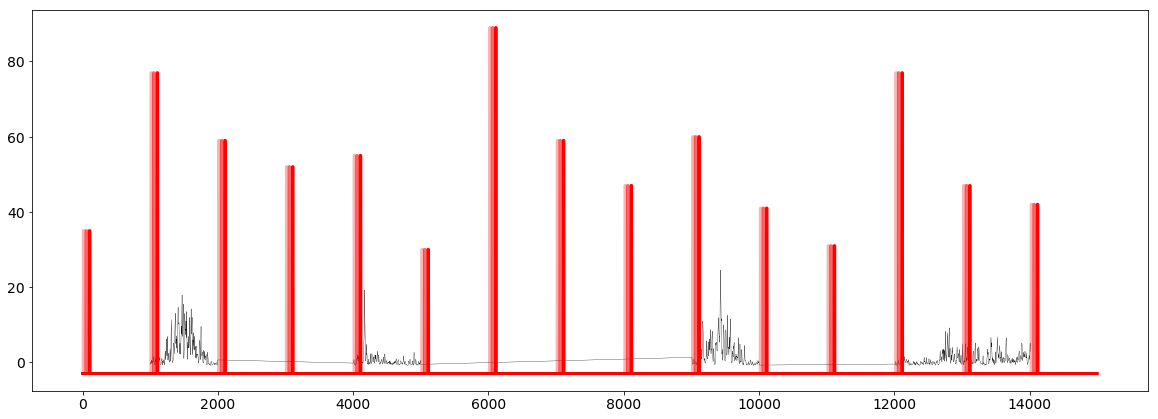

In [23]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = plt.plot(data_math.loc[0:15000,'HFB'], 'k', linewidth=0.3)
ax = plt.plot(X_env[0:15000,10]-3, color = [1, 0, 0, 1], linewidth=3)
ax = plt.plot(X_env[0:15000,5]-3, color = [1, 0, 0, 0.6], linewidth=3)
ax = plt.plot(X_env[0:15000,1]-3, color = [1, 0, 0, 0.3], linewidth=3)

In [28]:
trials

160